# 导入模型

In [128]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv(dotenv_path=r"E:\Workplace\GitHub\Learning\LangChain\.env", override=True)

model_ds = ChatOpenAI(
                    # temperature=0.1,
                    # max_tokens=2048,
                    # presence_penalty=1.2,
                    model='deepseek-chat',
                    openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    openai_api_base="https://api.deepseek.com/v1",
                    # model='gpt-4o-mini',
                    # openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    # openai_api_base="https://api.openai-proxy.org/v1",
                    # model='yi-large-fc',
                    # openai_api_key=os.getenv('YI_API_KEY'),
                    # openai_api_base="https://api.lingyiwanwu.com/v1",
                )

model_yi = ChatOpenAI(
                    # temperature=0.1,
                    # max_tokens=2048,
                    # presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    # model='gpt-4o-mini',
                    # openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    # openai_api_base="https://api.openai-proxy.org/v1",
                    model='yi-large-fc',
                    openai_api_key=os.getenv('YI_API_KEY'),
                    openai_api_base="https://api.lingyiwanwu.com/v1",
                )

model_gpt = ChatOpenAI(
                    # temperature=0.1,
                    # max_tokens=2048,
                    # presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    # model='gpt-4o-2024-11-20',
                    model='gpt-4o',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                    # model='yi-large-fc',
                    # openai_api_key=os.getenv('YI_API_KEY'),
                    # openai_api_base="https://api.lingyiwanwu.com/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embeddings = HuggingFaceEmbeddings(
            model_name=r"E:/Workplace/GitHub/Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

# 构建RAG系统

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import BaseMessage, AnyMessage, HumanMessage, AIMessage, trim_messages
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_milvus.vectorstores.milvus import Milvus


loader = TextLoader(
    file_path="三国演义.txt",
    autodetect_encoding=True,
)

docs = loader.load()

splitter = RecursiveCharacterTextSplitter(
    separators=["。|！|？", "\.\s|\!\s|\?\s", "；|;\s", "，|,\s"],  # 定义分割符
    keep_separator="end",
    is_separator_regex=True,
    chunk_size=100,  # 每块大小
    chunk_overlap=0,  # 重叠大小
)

chunks = splitter.split_documents(docs)

print(len(chunks))

db = Milvus(
        embedding_function=embeddings,
        collection_name="sg",
        connection_args={"uri": "https://in05-e9b7822ca8ff8bb.serverless.ali-cn-hangzhou.cloud.zilliz.com.cn",
                         "token": "7dc031089e6d2095e90ddb01b22837bb68f444658e6efdb726899623178d777b307be7a264fb8014b445786993ce898d7e93e486"},
        drop_old=True,
        auto_id=True,
        enable_dynamic_field=True
    )
db.add_documents(chunks)

# prompt = ChatPromptTemplate(
#     [
#         (
#             "user",
#             "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:",
#         )
#     ]
# )

trimmer = trim_messages(strategy="last", max_tokens=6, token_counter=len)


614


c:\Users\farben\anaconda3\envs\lclg\Lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


# LangGraph Agent实现

In [129]:
from langchain_core.messages import AIMessageChunk, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent



@tool
def retrieve(query: str):
    """根据 query 从知识库中检索相关文档。"""
    try:
        # 解码Unicode字符串
        if "\\u" in query:
            import json
            query = json.loads(f'"{query}"')

        retrieved_docs = db.similarity_search_with_relevance_scores(query, k=4, score_threshold=0.8)
        if not retrieved_docs:
            return ""  # 如果没有检索到相关文档，返回空字符串
            
        serialized = "\n\n".join(
            (f"Content: {doc.page_content}")
            for doc, score in retrieved_docs if score >= 0.8  # 确保分数达标
        )
        return serialized
    except Exception as e:
        print(f"检索出错: {e}")
        return ""

@tool
def search(query: str):
    """根据 query 从网络上搜索相关信息。"""
    try:
        # 解码Unicode字符串
        if "\\u" in query:
            import json
            query = json.loads(f'"{query}"')
            
        searcher = TavilySearchResults(max_results=2)
        search_results = searcher.invoke(query)
        if not search_results:
            return ""
            
        serialized = "\n\n".join(
            (f"Content: {result['content']}")
            for result in search_results if result.get('content')
        )
        return serialized
    except Exception as e:
        print(f"搜索出错: {e}")
        return ""

graph_builder = StateGraph(MessagesState)

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tool_retrieve = model_gpt.bind_tools(
        tools=[retrieve, search],
        tool_choice={
            "type": "function",
            "function": {"name": "retrieve"}
        },
        strict=True  # 确保输出严格匹配工具定义
    )       
    response = llm_with_tool_retrieve.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

def select_query_or_respond(
    state: MessagesState,
):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tool_retrieve"
    return END

    
tool_retrieve = ToolNode(tools=[retrieve], 
                         name="tool_retrieve")

def search_or_generate(state: MessagesState):
    # 确保state中有messages且不为空
    if not state.get("messages"):
        return {"messages": []}
    
    last_message = state["messages"][-1]
    
    # 处理工具消息
    if last_message.type == "tool":
        if not last_message.content:  # 如果工具返回空内容
            llm_with_tool_search = model_gpt.bind_tools(
                tools=[retrieve, search],
                tool_choice={
                    "type": "function",
                    "function": {"name": "search"}
                },
                strict=True
            )
            response = llm_with_tool_search.invoke(state["messages"])
            return {"messages": [response]}
        else:
            # 如果工具返回了内容，直接返回当前状态
            return state
    
    # 处理AI消息且包含工具调用
    elif last_message.type == "ai" and hasattr(last_message, "tool_calls"):
        llm_with_tool_search = model_gpt.bind_tools(
            tools=[retrieve, search],
            tool_choice={
                "type": "function",
                "function": {"name": "search"}
            },
            strict=True
        )
        response = llm_with_tool_search.invoke(state["messages"])
        return {"messages": [response]}
    
    # 处理其他情况
    return state


def select_search_or_generate(state: MessagesState):
    if isinstance(state, list):
        last_message = state[-1]
    elif messages := state.get("messages", []):
        last_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # 确保总是返回一个有效的节点名称
    if last_message.type == "tool":
        if last_message.content == "":  # 如果工具返回空内容
            return "tool_webSearch"
        return "generate"
    elif last_message.type == "ai" and last_message.tool_calls:
        return "tool_webSearch"
    return "generate"  # 默认返回generate节点

tool_webSearch = ToolNode(tools=[search], 
                         name="tool_webSearch")

def generate(state: MessagesState):
    """Generate answer."""
    try:
        # Get generated ToolMessages
        recent_tool_messages = []
        for message in reversed(state["messages"]):
            if message.type == "tool":
                recent_tool_messages.append(message)
            else:
                break
                
        if not recent_tool_messages:
            return {"messages": [AIMessage(content="抱歉，没有找到相关信息。")]}
            
        tool_messages = recent_tool_messages[::-1]

        # Format into prompt
        docs_content = "\n\n".join(doc.content for doc in tool_messages if doc.content)
        if not docs_content:
            return {"messages": [AIMessage(content="抱歉，没有找到相关信息。")]}
            
        system_message_content = (
            "You are an assistant for question-answering tasks. "
            "Use the following pieces of retrieved context to answer "
            "the question. If you don't know the answer, say that you "
            "don't know. Use three sentences maximum and keep the "
            "answer concise."
            "\n\n"
            f"{docs_content}"
        )
        
        conversation_messages = [
            message
            for message in state["messages"]
            if message.type in ("human", "system")
            or (message.type == "ai" and not message.tool_calls)
        ]
        
        trimmed_conversation_messages = trimmer.invoke(conversation_messages)
        prompt = [SystemMessage(system_message_content)] + trimmed_conversation_messages
        
        # Run
        response = model_ds.invoke(prompt)
        return {"messages": [response]}
        
    except Exception as e:
        print(f"生成回答时出错: {e}")
        return {"messages": [AIMessage(content="抱歉，处理您的请求时出现错误。")]}



graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("tool_retrieve", tool_retrieve)
graph_builder.add_node("search_or_generate", search_or_generate)
graph_builder.add_node("tool_webSearch", tool_webSearch)
graph_builder.add_node("generate", generate)

graph_builder.add_edge(START, "query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    select_query_or_respond,
    {"tool_retrieve": "tool_retrieve", END: END},
)
graph_builder.add_edge("tool_retrieve", "search_or_generate")
graph_builder.add_conditional_edges(
    "search_or_generate",
    select_search_or_generate,
    {"tool_webSearch": "tool_webSearch", "generate": "generate"},
)
graph_builder.add_edge("tool_webSearch", "generate")
graph_builder.add_edge("generate", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


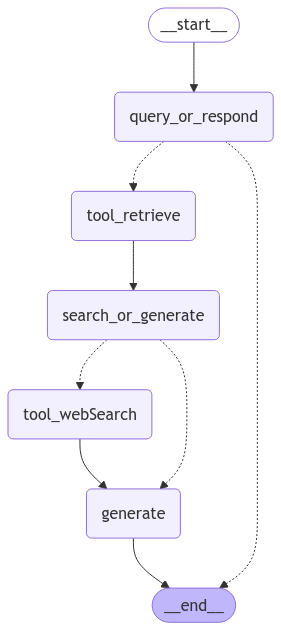

In [16]:
graph

In [ ]:
retrieved_docs = db.similarity_search_with_relevance_scores("张飞怎么去世", k=4, score_threshold=0.8)
retrieved_docs

In [138]:
# input_message = "诸葛亮的哥哥是谁？"
# input_message = "他的哥哥在哪个阵营？参加过什么战役？"
# input_message = "他的弟弟的官职最高是什么？"
input_message = "西游记是谁写的？"

config = {"configurable": {"thread_id": "1"}}

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    config=config,
    stream_mode="values",
):
    final_result = step

final_result["messages"][-1].pretty_print()

No relevant docs were retrieved using the relevance score threshold 0.8


================================== Ai Message ==================================

《西游记》一般认为是由明朝的吴承恩所著。


In [139]:
graph.get_state(config=config).values["messages"]

[HumanMessage(content='诸葛亮的哥哥是谁？', additional_kwargs={}, response_metadata={}, id='dc136454-4a2e-4c00-9e47-0a27835bd8f4'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oP0UbnuuJqLonUaZiSIpHFLJ', 'function': {'arguments': '{"query":"诸葛亮的哥哥是谁"}', 'name': 'retrieve'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 85, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ec7eab8ec3', 'finish_reason': 'stop', 'logprobs': None}, id='run-8b92d8bf-371c-4d11-aeca-a714e9cc4398-0', tool_calls=[{'name': 'retrieve', 'args': {'query': '诸葛亮的哥哥是谁'}, 'id': 'call_oP0UbnuuJqLonUaZiSIpHFLJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 11, 'total_token

# Stream

In [130]:
config = {"configurable": {"thread_id": "2"}}

In [133]:
# input_message = "诸葛亮的弟弟是谁？"
# input_message = "司马懿有几个儿子？都叫什么名字？"
input_message = "徐晃在哪个阵营？"
# input_message = "西游记是谁写的？"

async for msg, metadata in graph.astream({"messages": [("user", input_message)]}, 
                                         config=config,
                                         stream_mode="messages"):
    if isinstance(msg, AIMessageChunk) and msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)
    # print(msg)

No relevant docs were retrieved using the relevance score threshold 0.8


徐晃在魏阵营。

In [134]:
graph.get_state(config=config).values["messages"]

[HumanMessage(content='诸葛亮的弟弟是谁？', additional_kwargs={}, response_metadata={}, id='c0d0d406-b705-4fbf-b72e-867e987ecd40'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_6eFESTnTbvLUxOr2vT5e57rD', 'function': {'arguments': '{"query":"诸葛亮的弟弟是谁"}', 'name': 'retrieve'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ec7eab8ec3'}, id='run-e7f4c969-a072-4fd6-aee3-d5d05ef51d33', tool_calls=[{'name': 'retrieve', 'args': {'query': '诸葛亮的弟弟是谁'}, 'id': 'call_6eFESTnTbvLUxOr2vT5e57rD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 11, 'total_tokens': 97, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content='', name='retrieve', id='a9bf29e5-0690-4bd9-b1e9-f8c8f0a4c43e', tool_call_id='call_6eFESTnTbvLUxOr2vT5e57rD'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'inde